# Project - NLP with disaster tweets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
tf.__version__

'2.2.0-rc3'

In [3]:
train = pd.read_csv("nlp-getting-started/train.csv")
test = pd.read_csv("nlp-getting-started/test.csv")

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.shape

(7613, 5)

In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
test.shape

(3263, 4)

**Let's look to an example of a non disaster tweet:**

In [74]:
train[train["target"]==0]["text"].values[1]

'I love fruits'

**Now, a disaster one :**

In [9]:
train[train["target"]==1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [10]:
train.target.value_counts(1)

0    0.57034
1    0.42966
Name: target, dtype: float64

**Missing values ?**

In [11]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
train.location = train["location"].fillna("no_location")
train.keyword = train.keyword.fillna("no_keyword")

## Preprocessing

In [75]:
# Créating a tf dataset from pandas 
tf_ds = tf.data.Dataset.from_tensor_slices((train.text.values,train.target.values))

In [76]:
tf_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [77]:
# Let's look at an example: 
for text, target in tf_ds.take(1):
    print(text,target)

tf.Tensor(b'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all', shape=(), dtype=string) tf.Tensor(1, shape=(), dtype=int64)


In [78]:
# Shuffle the dataset 
BUFFER_SIZE = len(train)

tf_ds = tf_ds.shuffle(BUFFER_SIZE)

In [79]:
# tokenizing each words and removing duplicates witt set()
tokenizer = tfds.features.text.Tokenizer()
vocabulary_set = set()
for text, _ in tf_ds:
    doc_1 = tokenizer.tokenize(text.numpy())
    vocabulary_set.update(doc_1) 

In [80]:
vocab_size = len(vocabulary_set)
vocab_size

25863

In [19]:
# Creating a number for each token
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [81]:
encoder.vocab_size

25865

In [82]:
# Let's look at an example:
for example, _ in tf_ds.take(1):
    enc = encoder.encode(example.numpy())
    print(enc)
    print(example.numpy())
    print(encoder.decode(enc))

[7691, 21012, 17241, 21515, 19611, 5458, 3330, 5363, 19041, 25086, 13420, 15421, 14885, 9009, 25229, 4395, 1479, 17660, 11406, 16541]
b"There's a Storm over Cairo in the latest 'X-Men Apocalypse' set photo https://t.co/fS012trUDG via @YahooTV"
There s a Storm over Cairo in the latest X Men Apocalypse set photo https t co fS012trUDG via YahooTV


In [83]:
# Encoding all elements of a dataset
def encode(text, target):
    encoded_text = encoder.encode(text.numpy())
    return encoded_text, target

# Use of py_function to encode the entire dataset 
def encode_map(text, target):
    encoded_text, target = tf.py_function(encode, inp=[text, target], Tout=(tf.int64, tf.int64))

# `tf.data.Datasets` work best if all components have a shape set
#  so set the shapes manually:

    encoded_text.set_shape([None])
    target.set_shape([])
    
    return encoded_text, target

In [84]:
encoded_data = tf_ds.map(encode_map) 

In [85]:
DROP_SIZE = int(0.30 * len(train))

train_data = encoded_data.skip(DROP_SIZE).shuffle(BUFFER_SIZE)
validation_data = encoded_data.take(DROP_SIZE)

In [99]:
print(len([i for i in train_data]))
len([i for i in validation_data])

334


143

In [87]:
BATCH_SIZE = 16

train_data = train_data.padded_batch(BATCH_SIZE)
validation_data = validation_data.padded_batch(BATCH_SIZE)

In [56]:
# Let's look at a batch 
for text, target in train_data.take(1):
    print(text, target)

tf.Tensor(
[[[ 8823 10279 24293 ...     0     0     0]
  [14365 21949 19044 ...     0     0     0]
  [ 2134  3076 16770 ...     0     0     0]
  ...
  [15493 17034 18492 ...     0     0     0]
  [ 1215  1793  2162 ...     0     0     0]
  [ 8469  6422  5363 ...     0     0     0]]

 [[ 6904 22883  9773 ...     0     0     0]
  [19464  3330 19041 ...     0     0     0]
  [17698 22597 18141 ...     0     0     0]
  ...
  [22262  3330  9283 ...     0     0     0]
  [ 8052 11355 17034 ...     0     0     0]
  [24837 25349  6225 ...     0     0     0]]

 [[ 1418  3270 17045 ...     0     0     0]
  [14352 19411  8823 ...     0     0     0]
  [17598 16415 11448 ...     0     0     0]
  ...
  [24552  7834   907 ...     0     0     0]
  [ 8823 24749 17241 ...     0     0     0]
  [16010 23602 20673 ...     0     0     0]]

 ...

 [[14125  5845  4098 ...     0     0     0]
  [ 4033   789  7521 ...     0     0     0]
  [23786  2134  6284 ...     0     0     0]
  ...
  [ 6436  7216  6879 ...     

## Creating the model

In [89]:
model = tf.keras.Sequential()

In [90]:
# The first layer converts integer representations to dense vector embeddings.
model.add(tf.keras.layers.Embedding(encoder.vocab_size, 64))

In [91]:
# The next layer is a Long Short-Term Memory layer, 
# which lets the model understand words in their context with other words. 
# A bidirectional wrapper on the LSTM helps it to learn about the datapoints 
# in relationship to the datapoints that came before it and after it.

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

# Finally we'll have a series of one or more densely connected layers, 
# with the last one being the output layer. 
# The output layer produces a probability for all the labels. 
# The one with the highest probability is the models prediction of an example's label.

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Output layer. The first argument is the number of labels.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [92]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          1655360   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 1,731,777
Trainable params: 1,731,777
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.binary_accuracy])

In [94]:
history = model.fit(train_data, epochs=15, validation_data=validation_data)

Epoch 1/15
334/334 [==============================] - 24s 71ms/step - loss: 0.5378 - binary_accuracy: 0.7276 - val_loss: 0.3699 - val_binary_accuracy: 0.8730
Epoch 2/15
334/334 [==============================] - 22s 64ms/step - loss: 0.3227 - binary_accuracy: 0.8698 - val_loss: 0.2092 - val_binary_accuracy: 0.9347
Epoch 3/15
334/334 [==============================] - 21s 63ms/step - loss: 0.1968 - binary_accuracy: 0.9276 - val_loss: 0.1173 - val_binary_accuracy: 0.9654
Epoch 4/15
334/334 [==============================] - 20s 61ms/step - loss: 0.1205 - binary_accuracy: 0.9574 - val_loss: 0.0624 - val_binary_accuracy: 0.9781
Epoch 5/15
334/334 [==============================] - 30s 89ms/step - loss: 0.0789 - binary_accuracy: 0.9743 - val_loss: 0.0376 - val_binary_accuracy: 0.9860
Epoch 6/15
334/334 [==============================] - 25s 76ms/step - loss: 0.0509 - binary_accuracy: 0.9846 - val_loss: 0.0277 - val_binary_accuracy: 0.9904
Epoch 7/15
334/334 [==============================] 

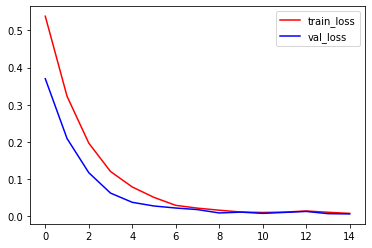

In [95]:
plt.plot(history.history["loss"], c="r", label="train_loss")
plt.plot(history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper right")
plt.show()

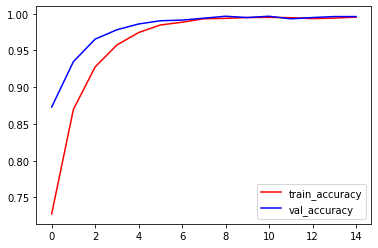

In [100]:
plt.plot(history.history["binary_accuracy"], c="r", label="train_accuracy")
plt.plot(history.history["val_binary_accuracy"], c="b", label="val_accuracy")
plt.legend(loc="lower right")
plt.show()